## Treinando o modelo - Machine Learning

- Nesta fase do projeto iniciarei com treinamento do modelos, para a escolha do algoritmo que será utilizado no deploy do mesmo.
- Inicialmente irei utilizar um modelo básico como basiline do projeto. A pergunta que quero responder, é se é possivel treinar um modelo consistente utilizando apenas duas variáveis, o preço e o ano do carro.
- Irei utilizar um modelo simples de árvore decisão, para analisar se o mesmo consegue achar padrões nos dados com estas duas importantes variáveis que utilizei para a escolha dos carros preferidos.

In [97]:
!pip install scikit-optimize

In [1]:
#Importando as bibliotecas

import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from scipy.sparse import csr_matrix

from lightgbm import LGBMClassifier
from skopt import forest_minimize

import matplotlib.pyplot as plt

import joblib as jb

pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

#pd.set_option('max_columns', 28)

pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('car_information_model.csv', index_col = 0)
df = df[df['Y'].notnull()]

In [4]:
df.head()

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_-652553591,52900,2016,78000,spin activ 1.8 8v econo. flex 5p aut.,4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_-721380430,34900,2015,89000,ka sedan 1.0 sel ticvt flex 4p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_1-4-lt-com-central-multimidia-e-rodas-de-liga-749612640,50900,2019,31709,prisma sed. lt 1.4 8v flexpower 4p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_1000-755988722,29000,2013,100000,focus 1.8 16v 5p,2,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_12-13-celta-ls-1-0-flex-vidro-ar-quente-limp-desemb-758957011,16500,2013,106859,celta life ls 1.0 mpfi 8v flexpower 3p,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
# selecionando as colunas. 

cols = ['price', 'regdate', 'Y']

In [6]:
# Irei embaralhar o dataframe, para retirar qualquer viés em relação aos modelos dos carros que estão em ordem no df original.

df = shuffle(df).reset_index(drop=True)
df.head()

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_saveiro-st-2015-2016-758584170,33000,2016,100000,saveiro startline 1.6 t.flex 8v,2,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_ford-fiesta-16sel-758493803,41900,2017,24529,fiesta sel 1.6 16v flex mec. 5p,4,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_jetta-confortline-1-4-turbo-250-18-18-754214752,76500,2018,11000,jetta comfort. 250 tsi 1.4 flex 16v aut.,4,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_vw-polo-1-0-0km-2020-2020-761364625,43000,2020,333,polo 1.0 flex 12v 5p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_chevrolet-tracker-premier-1-4-turbo-16v-flex-aut-758522047,79900,2018,38035,tracker premier 1.4 turbo 16v flex aut,4,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [8]:
#Salvando uma instancia com as colunas.

simple_df = df[cols]
simple_df.head(20)

,price,regdate,Y
0,33000,2016,0
1,41900,2017,0
2,76500,2018,0
3,43000,2020,0
4,79900,2018,0
5,18900,2014,0
6,33900,2017,0
7,68900,2015,0
8,35790,2019,0
9,73000,2018,0


In [9]:
#Dividindo o df nas variáveis independentes e a dependente (Y).

X = simple_df.loc[:,'price':'regdate']
Y = simple_df['Y']

In [10]:
X.shape

(11593, 2)

In [11]:
Y.shape

(11593,)

In [18]:
#Dividindo os dados em treino e teste, sendo metade dos dados para treino e outra metade para teste.
#Estou usando essa divisão igual devido ao grande numero de amostras em meu dataset.

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42 )

In [19]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5796, 2), (5797, 2), (5796,), (5797,))

**Treinando o Modelo - DecisionTree**

- Lembrando que as classe se aprezsentam desbalanceadas, portanto irei utilizar o hiperparâmetro class_weight = 'balanced', onde o algoritmo ajusta automaticamente os pesos de acordo com a proporção das frequências de cada classe.

In [45]:
#Instanciando o modelo.

model = DecisionTreeClassifier( random_state = 42, max_depth = 3, class_weight= 'balanced')

In [46]:
#treinando

model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
#função para ver a divisao dos dados

#fig, ax = plt.subplots()

#decision_boundary(model, simple_df, ax)

In [21]:
x_test

,price,regdate
6298,31900,2017
4695,47900,2016
8051,28900,2013
4003,25500,2015
8923,34900,2014
1655,37900,2015
6464,21300,2014
7792,26000,2014
8076,33500,2014
200,28000,2014


In [47]:
#Fazendo a prvisão das classes.

pred = model.predict_proba(x_test)[:,1]

In [48]:
pred

array([0.57081438, 0.88659878, 0.51196177, ..., 0.        , 0.88659878,
       0.51196177])

**Metricas de validação**

In [49]:
print('average_precision_score: ', np.round(average_precision_score(y_test, pred),4))
print('ROC_auc_score: ', np.round(roc_auc_score(y_test, pred), 4))

average_precision_score:  0.4617
ROC_auc_score:  0.878


- Por meio do simples algoritmo com apenas duas variáveis de entrada, obtivemos resultados favoráveis, para a classicação entre 0 e 1. O modelo obteve um Roc_auc de 0.878, considerado um bom número nessa métrica, pois obteve uma boa medida de separabilidade, portanto ocorreu a presença de verdadeiros-positivos em quase 90% da amostra.

**Plotando a DecisionTree**

In [29]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Andre\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


[Text(482.8846153846154, 713.475, 'price <= 37495.0\ngini = 0.5\nsamples = 5796\nvalue = [2898.0, 2898.0]'),
 Text(257.53846153846155, 509.625, 'price <= 34495.0\ngini = 0.267\nsamples = 2842\nvalue = [1618.83, 305.402]'),
 Text(128.76923076923077, 305.775, 'regdate <= 2013.5\ngini = 0.16\nsamples = 2146\nvalue = [1242.084, 119.505]'),
 Text(64.38461538461539, 101.92499999999995, 'gini = 0.0\nsamples = 858\nvalue = [505.075, 0.0]'),
 Text(193.15384615384616, 101.92499999999995, 'gini = 0.24\nsamples = 1288\nvalue = [737.009, 119.505]'),
 Text(386.3076923076923, 305.775, 'regdate <= 2015.5\ngini = 0.442\nsamples = 696\nvalue = [376.746, 185.897]'),
 Text(321.9230769230769, 101.92499999999995, 'gini = 0.49\nsamples = 262\nvalue = [124.797, 165.979]'),
 Text(450.69230769230774, 101.92499999999995, 'gini = 0.136\nsamples = 434\nvalue = [251.949, 19.918]'),
 Text(708.2307692307693, 509.625, 'price <= 59999.5\ngini = 0.442\nsamples = 2954\nvalue = [1279.17, 2592.598]'),
 Text(643.84615384615

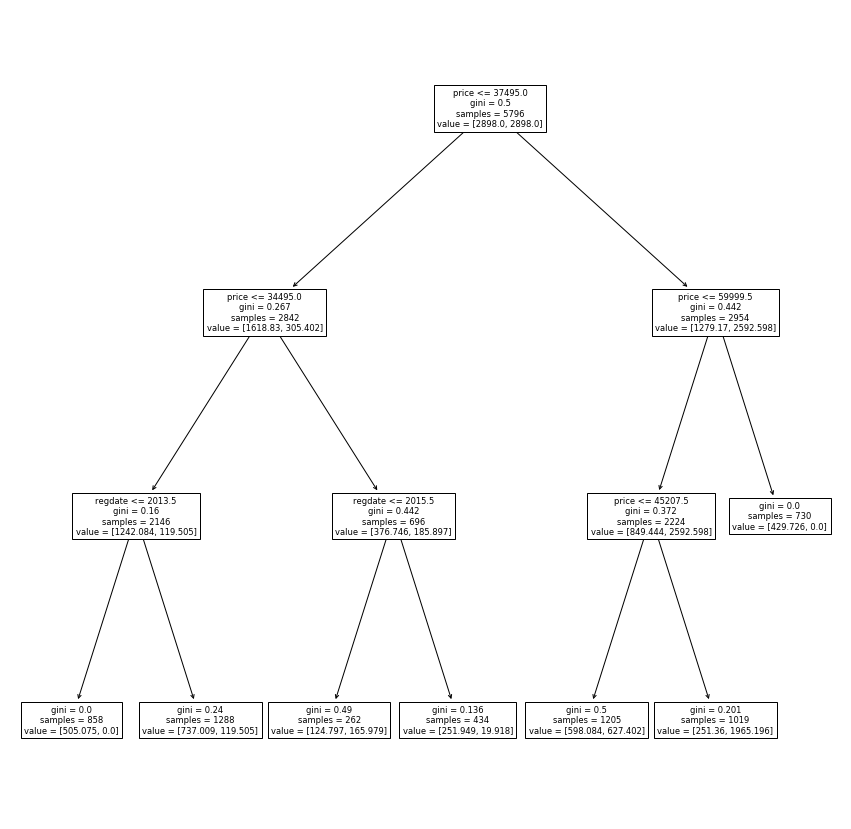

In [50]:
fig, ax = pylab.subplots(1,1, figsize = (15,15))
plot_tree(model, ax = ax, feature_names = x_train.columns)

Por meio da árvore de decisão apresentada acima, é possivel ver claramente a divisão dos dados. Ela se inicia dividindo os preços entre os menores de 37.495 e os maiores, o que ainda não segue minha preferência por carros abaixo de 60.000, com certeza aqui se tem um viés devido a preferência por cambios automáticos, o que indica carros mais caros, porém logo no segundo nó, ocorre está separação com carros de preços de 59.999 do lado direito e 34.495 ao lado esquerdo. Vemos essa diferenciação quando entra a variável regdate em que, cortei os carros abaixo de 2014, o que o nó tambem faz, é possivel ver essa preferência realizando as contas 165.979/(165.979 + 124.797) = 0.5708, que se apresenta no final da árvore nos anos de 2015 e o valor de 0.1395 quando se realiza o calculo de 119.505/(119.505 + 737.009), mostrando que o algoritmo está no caminho certo.

**Adicionando a variável indicativa do câmbio automático ao modelo**

- Irei adicionar a terceira variável corte utilizada para escolha dos carros para análisar a melhora na predição das classes. Irei utilizar novamento o algoritmo DecisonTree, para fazer um comparação com o anterior. Assim sendo utilizarei preço, e a variavel boolena, se possui ou não cambio automático.

In [54]:
df.head()

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_saveiro-st-2015-2016-758584170,33000,2016,100000,saveiro startline 1.6 t.flex 8v,2,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_ford-fiesta-16sel-758493803,41900,2017,24529,fiesta sel 1.6 16v flex mec. 5p,4,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_jetta-confortline-1-4-turbo-250-18-18-754214752,76500,2018,11000,jetta comfort. 250 tsi 1.4 flex 16v aut.,4,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_vw-polo-1-0-0km-2020-2020-761364625,43000,2020,333,polo 1.0 flex 12v 5p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_chevrolet-tracker-premier-1-4-turbo-16v-flex-aut-758522047,79900,2018,38035,tracker premier 1.4 turbo 16v flex aut,4,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [56]:
df['gearbox_automático']

0        0
1        0
2        1
3        0
4        1
5        0
6        0
7        0
8        0
9        1
10       1
11       1
12       0
13       0
14       0
15       1
16       1
17       1
18       0
19       0
20       1
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       1
30       1
31       1
32       0
33       0
34       0
35       0
36       0
37       0
38       1
39       1
40       0
41       1
42       0
43       1
44       1
45       0
46       1
47       0
48       1
49       0
50       0
51       0
52       0
53       0
54       0
55       1
56       1
57       1
58       0
59       0
60       0
61       0
62       1
63       0
64       1
65       0
66       0
67       1
68       0
69       0
70       1
71       0
72       0
73       0
74       1
75       1
76       1
77       1
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       1
88       1
89       1
90       0

In [97]:
cols = ['price', 'gearbox_automático', 'Y' ]

In [98]:
df_auto = df[cols]
df_auto.head(20)

,price,gearbox_automático,Y
0,33000,0,0
1,41900,0,0
2,76500,1,0
3,43000,0,0
4,79900,1,0
5,18900,0,0
6,33900,0,0
7,68900,0,0
8,35790,0,0
9,73000,1,0


In [ ]:
#Embaralhando as amostras, no caso ja foi realizado anteriormente

#df_auto = shuffle(df_auto).reset_index(drop=True)

In [88]:
Y = df_auto['Y']
X = df_auto[[ 'price', 'gearbox_automático' ]]

In [89]:
X.shape

(11593, 2)

In [90]:
Y.shape

(11593,)

In [91]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5796, 2), (5797, 2), (5796,), (5797,))

In [92]:
#Instanciando o modelo.

model = DecisionTreeClassifier( random_state = 42, max_depth = 3, class_weight= 'balanced')

In [93]:
#treinando

model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [94]:
#Fazendo a prvisão das classes.

pred = model.predict_proba(x_test)[:,1]

In [95]:
print('average_precision_score: ', np.round(average_precision_score(y_test, pred),4))
print('ROC_auc_score: ', np.round(roc_auc_score(y_test, pred), 4))

average_precision_score:  0.8619
ROC_auc_score:  0.9867


[Text(223.2, 475.65000000000003, 'gearbox_automático <= 0.5\ngini = 0.5\nsamples = 5796\nvalue = [2898.0, 2898.0]'),
 Text(111.6, 339.75, 'gini = -0.0\nsamples = 4161\nvalue = [2449.437, 0.0]'),
 Text(334.79999999999995, 339.75, 'price <= 59999.5\ngini = 0.232\nsamples = 1635\nvalue = [448.563, 2898.0]'),
 Text(223.2, 203.85000000000002, 'price <= 33950.0\ngini = 0.066\nsamples = 1048\nvalue = [103.016, 2898.0]'),
 Text(111.6, 67.94999999999999, 'gini = 0.33\nsamples = 87\nvalue = [30.611, 116.186]'),
 Text(334.79999999999995, 67.94999999999999, 'gini = 0.049\nsamples = 961\nvalue = [72.406, 2781.814]'),
 Text(446.4, 203.85000000000002, 'gini = 0.0\nsamples = 587\nvalue = [345.547, 0.0]')]

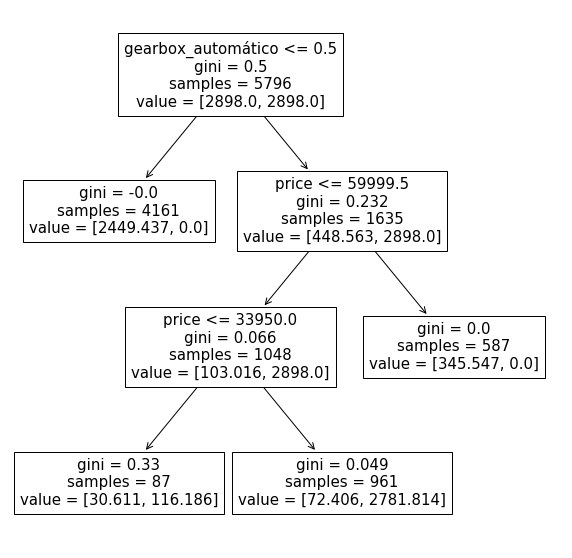

In [96]:
fig, ax = pylab.subplots(1,1, figsize = (10,10))
plot_tree(model, ax = ax, feature_names = x_train.columns)

- Podemos ver acima de como a árvore, captou corretamente os pontos de corte das duas variáveis que utilizei como preferência, que seria o câmbio ser automático e o carro possuir o valor menor que 60.000. Vemos que no primeiro nó o algorítmo começa exatamente separando entre o 0 não é automático e o 1 em que o carro é automatico, o que está correto. No segundo nó ocorre a separação entre os preços menores e maiores que 59.999, indo na direção correta, em relação as preferências.
- Escolhi variáveis que foram utilizadas para classificar os carros, portanto este resultado de 0.98, deve ser considerado como overfitting, caso resolva generalizar o modelo. Assim sendo na seguinte parte do projeto não utilizarei a variavei indicativa do câmbio automatico, por ser booleana e influenciar logo no inicio da divisão dos dados, tendendo o modelo assim ao overfitting.

**Adicionando outras variáveis ao modelo**

- Irei adicionar os restante das variáveis para realizar a escolha do algoritmo com melhor previsão.

Utilizarei: 

- Decision Tree
- Random Forest
- LightGBM
- Logistic Regression


In [45]:
#Importando novamente o dataset, sem o shuffle.

df = pd.read_csv('data/car_information_model.csv', index_col = 0)
df = df[df['Y'].notnull()]

In [46]:
df.head()

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_-652553591,52900,2016,78000,spin activ 1.8 8v econo. flex 5p aut.,4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_-721380430,34900,2015,89000,ka sedan 1.0 sel ticvt flex 4p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_1-4-lt-com-central-multimidia-e-rodas-de-liga-749612640,50900,2019,31709,prisma sed. lt 1.4 8v flexpower 4p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_1000-755988722,29000,2013,100000,focus 1.8 16v 5p,2,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_12-13-celta-ls-1-0-flex-vidro-ar-quente-limp-desemb-758957011,16500,2013,106859,celta life ls 1.0 mpfi 8v flexpower 3p,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [5]:
#Selecionando as colunas

columns = df.columns
columns

Index(['link', 'price', 'regdate', 'mileage', 'version', 'doors', 'Y',
       'vidro_elétrico', 'air_bag', 'trava_elétrica',
       ...
       'carcolor_branco', 'carcolor_cinza', 'carcolor_laranja',
       'carcolor_outra', 'carcolor_prata', 'carcolor_preto', 'carcolor_verde',
       'carcolor_vermelho', 'exchange_não', 'exchange_sim'],
      dtype='object', length=128)

In [47]:
#Todas as colunas do dataset

columns = ['link','price','regdate','mileage','version','doors','Y','vidro_elétrico',
           'air_bag','trava_elétrica','ar_condicionado','direção_hidráulica','alarme',
           'som','sensor_de_ré','blindado','camera_de_ré','financial_com multas','financial_de leilão',
           'financial_financiado','financial_ipva pago','brand_ford','brand_gmchevrolet','brand_honda',
           'brand_jeep','brand_mitsubishi','brand_nissan','brand_peugeot','brand_renault','brand_vwvolkswagen',
           'cartype_antigo','cartype_buggy','cartype_hatch','cartype_passeio','cartype_pickup','cartype_sedã',
           'cartype_suv','cartype_vanutilitário','model_aerostar','model_agile','model_captiva','model_celta',
           'model_chevette','model_classic','model_cobalt','model_compass','model_corsa','model_courier',
           'model_crossfox','model_cruze','model_duster','model_ecosport','model_edge','model_equinox',
           'model_escort','model_fiesta','model_fiorino','model_fit','model_focus','model_fox','model_fusca',
           'model_fusion','model_gol','model_golf','model_grandsaveiro','model_jetta','model_joy','model_ka',
           'model_kombi','model_l200','model_livina','model_montana','model_new','model_onix','model_pajero',
           'model_palio','model_parati','model_passat','model_polo','model_prisma','model_ranger','model_s10',
           'model_sandero','model_saveiro','model_sonic','model_spacecross','model_spacefox','model_spin',
           'model_tcross','model_tiguan','model_tracker','model_uno','model_up','model_variant',
           'model_virtus','model_voyage','gearbox_automático','gearbox_manual','gearbox_semiautomático',
           'motorpower_1.0','motorpower_1.2','motorpower_1.4','motorpower_1.5','motorpower_1.6',
           'motorpower_1.7','motorpower_1.8','motorpower_1.9','motorpower_2.02.9','motorpower_3.03.9',
           'motorpower_4.0oumais','fuel_flex','fuel_gasolina','car_steering_assistida','car_steering_elétrica',
           'car_steering_hidráulica','car_steering_mecnica','carcolor_amarelo','carcolor_azul',
           'carcolor_branco','carcolor_cinza','carcolor_laranja','carcolor_outra','carcolor_prata',
           'carcolor_preto','carcolor_verde','carcolor_vermelho','exchange_não','exchange_sim']

In [48]:
df.rename(columns = {'financial_com multas':'financial_com_multas',
                    'financial_de leilão': 'financial_de_leilão',
                    'financial_ipva pago': 'financial_ipva_pago'}, inplace = True )

In [49]:
df.head(1)

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_-652553591,52900,2016,78000,spin activ 1.8 8v econo. flex 5p aut.,4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [50]:
#As colunas que possuem maior relação com a escolha dos carros preferidos á compra.

cols = ['price','regdate','mileage', 'vidro_elétrico',
        'air_bag','trava_elétrica','ar_condicionado','direção_hidráulica','alarme',
        'som','sensor_de_ré', 'financial_com_multas','financial_de_leilão',
        'financial_financiado','financial_ipva_pago','brand_ford','brand_gmchevrolet', 
        'brand_vwvolkswagen','model_agile','model_captiva','model_celta', 'model_cobalt','model_compass','model_corsa',
        'model_crossfox','model_cruze', 'model_focus','model_fox', 'model_gol','model_golf','model_grandsaveiro',
        'model_jetta','model_joy','model_ka', 'model_parati','model_passat','model_polo','model_prisma','model_ranger','model_s10',
        'model_sandero','model_saveiro', 'car_steering_assistida','car_steering_elétrica','car_steering_hidráulica','car_steering_mecnica', 'Y']

- Fiz as escolheas por meio das minhas caracteristicas que possuem maior peso para a escolha do carro. Vemos que não escolhi todos os modelos e nem todas as marcas.

In [51]:
#Realizando o shuffle do dataframe.

df = shuffle(df).reset_index(drop=True)

In [52]:
pd.set_option('max_columns', 28)

df.head(3)

,link,price,regdate,mileage,version,doors,Y,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,...,car_steering_hidráulica,car_steering_mecnica,carcolor_amarelo,carcolor_azul,carcolor_branco,carcolor_cinza,carcolor_laranja,carcolor_outra,carcolor_prata,carcolor_preto,carcolor_verde,carcolor_vermelho,exchange_não,exchange_sim
0,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_gol-trendline-2015-completo-740957378,28900,2015,80000,gol 1.0 trend power 8v 4p,4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_s10-ltz-2-5-flex-2017-completa-757193826,91000,2017,47000,s10 pick up ltz 2.5 flex 4x4 cd,4,0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,https://pr.olx.com.br/regiao-de-londrina/autos-e-pecas/carros-vans-e-utilitarios/link_gm-prisma-1-4-lt-automatico-2019-753754230,57900,2019,18400,prisma sed. lt 1.4 8v flexpower 4p aut.,4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [53]:
df_model = df[cols]
df_model.head()

,price,regdate,mileage,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,sensor_de_ré,financial_com_multas,financial_de_leilão,financial_financiado,...,model_ka,model_parati,model_passat,model_polo,model_prisma,model_ranger,model_s10,model_sandero,model_saveiro,car_steering_assistida,car_steering_elétrica,car_steering_hidráulica,car_steering_mecnica,Y
0,28900,2015,80000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,91000,2017,47000,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,57900,2019,18400,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3,35900,2018,81271,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,34000,2014,118000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [54]:
x = df_model.drop(['Y'], axis=1)
y = df_model['Y']

In [12]:
x.head(1)

,price,regdate,mileage,vidro_elétrico,air_bag,trava_elétrica,ar_condicionado,direção_hidráulica,alarme,som,sensor_de_ré,financial_com_multas,financial_de_leilão,financial_financiado,...,model_joy,model_ka,model_parati,model_passat,model_polo,model_prisma,model_ranger,model_s10,model_sandero,model_saveiro,car_steering_assistida,car_steering_elétrica,car_steering_hidráulica,car_steering_mecnica
0,51000,2018,30000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [55]:
#Utilizando train test split para a divisão dos dados.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state = 42)

In [56]:
#conferindo

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5796, 46), (5797, 46), (5796,), (5797,))

**Decision Tree**

- Lembrar de balancear o dataset pelo hiperparâmetro 'class_weight'.
- Irei diminuir a profundidade máxima da árvore de 3 para 2 para evitar overfitting, algo que poderia ocorrer com uma profundiade de 3, como no baseline.

In [19]:
#Instânciando

model = DecisionTreeClassifier(random_state = 42, max_depth = 2, class_weight= 'balanced')

In [20]:
#treinando

model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [21]:
#Prevendo

pred = model.predict_proba(x_test)[:,1]

**Métricas de avaliação**

In [22]:
print('average_precision_score :', np.round(average_precision_score(y_test, pred),4))
print('roc_auc_score :', np.round(roc_auc_score(y_test, pred),4))

average_precision_score : 0.3582
roc_auc_score : 0.8319


**Random Forest**

In [23]:
#Instânciando

model_rf = RandomForestClassifier(n_estimators = 500,
                                 random_state = 42,
                                 class_weight = 'balanced',
                                 n_jobs = -1)#usa todos os processadores

In [24]:
#treinando

model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [25]:
#Prevendo

pred_rf = model_rf.predict_proba(x_test)[:,1]

In [26]:
#métricas de validação

print('average_precision_score :', np.round(average_precision_score(y_test, pred_rf),4))
print('roc_auc_score :', np.round(roc_auc_score(y_test, pred_rf),4))

average_precision_score : 0.7844
roc_auc_score : 0.9491


**Tunning**

- Obtivemos ótimos resultados, utilizando a combinação de parâmetros anterior, porém para retirar a duvido de uma pequena melhora do modelo irei realizar o tunning do modelo, com outros hiperparâmetros.

In [83]:
#valores que serão testados dos estimadores

val_estimators = [100, 250, 500, 1000]

#o número minimo de amotras por nós

sample_leaf = [1, 2]

#dicionario que recebe a lista de parâmetros.

parameters_grid = dict(n_estimators = val_estimators,
                      min_samples_leaf = sample_leaf)

#Modelo

model_rf = RandomForestClassifier(random_state = 42,
                                 class_weight = 'balanced',
                                 n_jobs = -1)

#Testando as combinações com os parâmetros.

grid = RandomizedSearchCV(estimator = model_rf, param_distributions = parameters_grid, scoring = 'roc_auc')
grid.fit(x, y)

#Visualizando

print(f'Best params RF:{grid.best_params_}, Score:{grid.best_score_}')

C:\Users\Andre\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best params RF:{'n_estimators': 250, 'min_samples_leaf': 2}, Score:0.9563998908181418


In [84]:
#Realizando o treino do modelo novamente com os hiperparâmetros indicados no tunning.

#Instânciando

model_rf = RandomForestClassifier(n_estimators = 250,
                                 random_state = 42,
                                min_samples_leaf = 2,
                                 class_weight = 'balanced',
                                 n_jobs = -1)

In [85]:
#treinando

model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [86]:
#Prevendo

pred_rf = model_rf.predict_proba(x_test)[:,1]

In [87]:
#métricas de validação

print('average_precision_score :', np.round(average_precision_score(y_test, pred_rf),4))
print('roc_auc_score :', np.round(roc_auc_score(y_test, pred_rf),4))

average_precision_score : 0.8011
roc_auc_score : 0.9541


## LightGBM

- Utilizarei o LightGBM, devido a ser um algorítmo também baseado em árvores de decisão, porém apresenta maior velocidade de treinamento.

In [27]:
#Instânciando o modelo defaut

model_lgbm = LGBMClassifier(random_state = 42, class_weight='balanced', n_jobs = -1)

In [28]:
model_lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [29]:
pred = model_lgbm.predict_proba(x_test)[:,1]

In [30]:
#metricas

print('average_precision_score :', np.round(average_precision_score(y_test, pred),4))
print('roc_auc_score :', np.round(roc_auc_score(y_test, pred),4))

average_precision_score : 0.7964
roc_auc_score : 0.9604


**Tunning - Bayesian Optimization**

- Obtemos um ótimo resultado por meio do LGBM, porém acho ainda válido realizar um tunning dos hiperparâmetros.
- Utilizarei a Bayesian Optimization ao invés do Random Search, devido ao Bayesian, reduzir o tempo gasto para obter o conjunto ideal de parâmetros e trazer melhor desempenho de generalização ao conjunto de teste.

In [101]:
def t_lgbm(params):
    learning_rate = params[0]
    n_leaves = params[1]
    max_depth = params[2]
    min_child_samples = params[3]
    subsample =params[4]
    colsample_bytree = params[5]
    n_estimators = params[6]
    print(params)
    
    #estimando
    model_lgmb = LGBMClassifier(learning_rate= learning_rate,
                           num_leaves= n_leaves,
                           max_depth= max_depth,
                           min_child_samples= min_child_samples,
                           subsample= subsample,
                           colsample_bytree=colsample_bytree,
                           bagging_freq = 1,
                           n_estimators = n_estimators,
                           random_state= 42,
                           class_weight= 'balanced',
                           n_jobs= -1)
    
    model_lgmb.fit(x_train, y_train)
    
    pred_lgbm = model_lgmb.predict_proba(x_test)[:,1]
    
    
    print('average_precision_score: ', np.round(average_precision_score(y_test, pred_lgbm), 4))
    print('roc_auc_score: ', np.round(roc_auc_score(y_test, pred_lgbm), 4))
    print()
    
    return - average_precision_score(y_test, pred_lgbm)


dimensions = [(1e-2,1e-1, 'log-uniform'), #learning_rate
              (10,100), #num_leaves
              (1,25), # max depth
              (1,25), # min_child_samples
              (0.05,1.), # subsample 
              (0.05,1.), # colsample_bytree
              (100,1000), # n_estimators
              (1,5)] # min_df

result = forest_minimize(t_lgbm,
                         dimensions, 
                         random_state = 42,
                         n_random_starts = 30,
                         n_calls = 50,
                         verbose = 1)
    

Iteration No: 1 started. Evaluating function at random point.
[0.0625954818428754, 24, 11, 8, 0.6187255599871848, 0.19821770842031472, 566, 3]
average_precision_score:  0.8088
roc_auc_score:  0.9571

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.8567
Function value obtained: -0.8088
Current minimum: -0.8088
Iteration No: 2 started. Evaluating function at random point.
[0.028790479097932958, 33, 3, 22, 0.10359100007574526, 0.7358988336534836, 513, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
average_precision_score:  0.7782
roc_auc_score:  0.9511

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8463
Function value obtained: -0.7782
Current minimum: -0.8088
Iteration No: 3 started. Evaluating function at random point.
[0.015199348301309807, 30, 1, 12, 0.631070502463867, 0.05671298995873154, 956, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cu

average_precision_score:  0.8231
roc_auc_score:  0.9615

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 1.5389
Function value obtained: -0.8231
Current minimum: -0.8231
Iteration No: 21 started. Evaluating function at random point.
[0.013178481381249194, 53, 24, 15, 0.20987649006428405, 0.25782600859441673, 571, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
average_precision_score:  0.7902
roc_auc_score:  0.9538

Iteration No: 21 ended. Evaluation done at random point.
Time taken: 2.4157
Function value obtained: -0.7902
Current minimum: -0.8231
Iteration No: 22 started. Evaluating function at random point.
[0.025341724840778738, 71, 17, 20, 0.2845322596966712, 0.711489059197799, 486, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
average_precision_score:  0.7856
roc_auc_score:  0.9563

Iteration No: 22 ended. Evaluation done at random po

average_precision_score:  0.8166
roc_auc_score:  0.9599

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 3.6380
Function value obtained: -0.8166
Current minimum: -0.8245
Iteration No: 40 started. Searching for the next optimal point.
[0.025069697375402628, 18, 9, 6, 0.8213731238545986, 0.10553488719658413, 744, 2]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
average_precision_score:  0.7897
roc_auc_score:  0.9517

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 6.9986
Function value obtained: -0.7897
Current minimum: -0.8245
Iteration No: 41 started. Searching for the next optimal point.
[0.0350524190429264, 13, 19, 7, 0.5713287350974777, 0.12223550474291828, 964, 1]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
average_precision_score:  0.8154
roc_auc_score:  0.9584

Iteration No: 41 ended. Search f

- Melhores parâmetros LGBM

Iteration No: 23 ended. Evaluation done at random point.
Time taken: 5.4810
Function value obtained: -0.8144
Current minimum: -0.8231
Iteration No: 24 started. Evaluating function at random point.

- [0.022134578078538455, 10, 19, 2, 0.5543878541512797, 0.47539400634443707, 809, 4]

- average_precision_score:  0.8245
- roc_auc_score:  0.9618

**O modelo será treinando com os melhores parâmetros na fase de ensemble do projeto.**

## Observações:

- Outro algoritmo de classificação que também poderia ser utilizado é a Regressão Logística, mas como foram obtidas resultados altamente favoráveis, como roc_auc acima dos 0.9, tanto no Random Forest quanto no LGBM, optei por manter os dois e realizar uma **ensemble** dos mesmos a seguir.

**Random Forest**

In [57]:
#Instânciando

model_rf = RandomForestClassifier(n_estimators = 500,
                                 random_state = 42,
                                 class_weight = 'balanced',
                                 n_jobs = -1)

In [58]:
#treinando

model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [72]:
#Prevendo

pred_rf = model_rf.predict_proba(x_test)[:,1]
pred_rf

array([0.002, 0.892, 0.988, ..., 0.13 , 0.634, 0.03 ])

In [60]:
print('average_precision_score: ', np.round(average_precision_score(y_test, pred_rf),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, pred_rf),4))

average_precision_score:  0.81
roc_auc_score:  0.9581


**LightGBM**

In [61]:
best = [0.022134578078538455, 10, 19, 2, 0.5543878541512797, 0.47539400634443707, 809, 4]

learning_rate = best[0]
num_leaves = best[1]
max_depth = best[2]
min_child_samples = best[3]
subsample = best[4]
colsample_bytree = best[5]
n_estimators = best[6]
min_df = best[7]


In [62]:
#Instânciando

model_lgbm = LGBMClassifier(learning_rate= learning_rate,
                       num_leaves= num_leaves,
                       max_depth= max_depth,
                       min_child_samples= min_child_samples,
                       subsample= subsample,
                       colsample_bytree=colsample_bytree,
                       bagging_freq = 1,
                       n_estimators = n_estimators,
                       random_state= 42,
                       class_weight= 'balanced',
                       n_jobs= -1)

In [63]:
#Treinando

model_lgbm.fit(x_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.47539400634443707, importance_type='split',
               learning_rate=0.022134578078538455, max_depth=19,
               min_child_samples=2, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=809, n_jobs=-1, num_leaves=10, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.5543878541512797, subsample_for_bin=200000,
               subsample_freq=0)

In [64]:
#Prevendo
pred_lgbm = model_lgbm.predict_proba(x_test)[:,1]

In [65]:
print('average_precision_score: ', np.round(average_precision_score(y_test, pred_lgbm),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, pred_lgbm),4))

average_precision_score:  0.8269
roc_auc_score:  0.9651


**Ensemble**

- Agora vou analisar as correlações entre os dois modelos, e analisar se a junção dos dois em diferentes proporções levará a uma melhor estimação.

In [40]:
pd.DataFrame({'RF': pred_rf, 'LGBM': pred_lgbm}).corr()

,RF,LGBM
RF,1.000000,0.904177
LGBM,0.904177,1.000000


In [120]:
#Média entre os dosi modelos.
e = (pred_rf + pred_lgbm)/2

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.822
roc_auc_score:  0.9621


- Utilizando a média entre as previsão dos dois modelos melhoramos um pouco a métrica curva roc.

In [68]:
# 0.1 (RF) e 0.9(LGBM)

e = 0.1*pred_rf + 0.9*pred_lgbm

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print( np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.8356
0.966


In [69]:
e

array([0.00652629, 0.9278191 , 0.98044893, ..., 0.49621459, 0.90742842,
       0.0033889 ])

In [66]:
# 0.2 (RF) e 0.8(LGBM)

e = 0.2*pred_rf + 0.8*pred_lgbm

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.8348
roc_auc_score:  0.9663


In [123]:
# 0.3 (RF) e 0.7(LGBM)

e = 0.3*pred_rf + 0.7*pred_lgbm

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.8243
roc_auc_score:  0.9625


In [125]:
# 0.6 (RF) e 0.4(LGBM)

e = 0.6*pred_rf + 0.4*pred_lgbm

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.8203
roc_auc_score:  0.9616


In [126]:
# 0.8 (RF) e 0.2(LGBM)

e = 0.8*pred_rf + 0.2*pred_lgbm

print('average_precision_score: ', np.round(average_precision_score(y_test, e),4))
print('roc_auc_score: ', np.round(roc_auc_score(y_test, e),4))

average_precision_score:  0.8155
roc_auc_score:  0.9597


- Como visto na ensemble a melhor precisão e roc_auc está presente na junção de 20% do random forest e 80% do LGBM.
- Porém a mudança e insignificante quando comparado com o melhor algoritmo o LGBM. Salvarei assim para um análise posterior em produção ambos.

In [70]:
#Salvando os modelos para o deploy.

jb.dump(model_rf, "model_rf.pk.z")
jb.dump(model_lgbm, "model_lgbm.pk;.z")

['model_lgbm.pk;.z']

In [41]:
jb.dump(model_rf, "model_rf.pkl")
jb.dump(model_lgbm, "model_lgbm.pkl")

['model_lgbm.pkl']

In [71]:
df_t = pd.read_json('novos_carros.json',lines = True)
df_t.head()

,car,score,car_id,update_time
0,focus tita tita plus 2.0 flex 5p aut.,0,https://pr.olx.com.br/regiao-de-curitiba-e-paranagua/autos-e-pecas/carros-vans-e-utilitarios/ford-focus-sedan-titanium-2-0-powershift-aut-2016-644500704,2020-09-25 18:47:45.506558100
1,ka,0,https://pr.olx.com.br/regiao-de-curitiba-e-paranagua/autos-e-pecas/carros-vans-e-utilitarios/ford-ka-1-0-s-12v-flex-4p-manual-777178483,2020-09-25 18:47:46.201550100
2,ka 1.0 se 12v flex 4p manual,0,https://pr.olx.com.br/regiao-de-curitiba-e-paranagua/autos-e-pecas/carros-vans-e-utilitarios/ford-ka-1-0-se-12v-flex-4p-775259695,2020-09-25 18:47:46.969222500
3,fiesta 1.6 16v flex mec. 5p,0,https://pr.olx.com.br/regiao-de-ponta-grossa-e-guarapuava/autos-e-pecas/carros-vans-e-utilitarios/fiesta-1-6-2014-completissimo-particular-794011522,2020-09-25 18:47:47.551437000
4,fiesta se 1.0 8v flex 5p,0,https://pr.olx.com.br/regiao-de-ponta-grossa-e-guarapuava/autos-e-pecas/carros-vans-e-utilitarios/fiesta-hatch-2014-se-1-0-completo-771949399,2020-09-25 18:47:48.173373900
